In [15]:
import torch 
from torch import nn
from Ford_dataset import SatGrdDatasetFord, train_logs, train_logs_img_inds, test_logs, test_logs_img_inds
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import models 

class Config():
    device = 'cpu'
    cameras = ['FL', 'SL']

    orig_satmap_A = 512
    sat_map_A = 64
    meter_per_pixel = 0.22 # this is fixed for the ford dataset meter per pixel of the original shape satellite map 512 * 512 

    vol_car_xyz = torch.tensor([128, 128, 6], dtype=torch.int64)   #volume around car xyz shape  
    orig_img_H = 448 #original image height that is going as input into the neural network 
    orig_img_W = 896
    img_H = 448//8 #the output shape of the image encoder, later to be lifted to 3D 
    img_W = 896//8
    batch_size = 1

config = Config()

logs_start = 0; logs_end = 1
range_lat = 20; range_lot=20; rotation_range =20; #meters, meters, degress

train_set  = SatGrdDatasetFord(logs=train_logs[logs_start:logs_end], logs_img_inds=train_logs_img_inds[logs_start:logs_end], H=config.orig_img_H, W=config.orig_img_W, cameras=config.cameras, mode='train')
val_set    = SatGrdDatasetFord(logs=test_logs[logs_start:logs_end],  logs_img_inds=test_logs_img_inds[logs_start:logs_end],  H=config.orig_img_H, W=config.orig_img_W, cameras=config.cameras, mode='val')

# train_loader = DataLoader(train_set, batch_size=1, shuffle=False)

Rs = {key:item.to(config.device) for key, item in train_set.Rs.items()}
Ts = {key:item.to(config.device) for key, item in train_set.Ts.items()}
Ks = {key:item.to(config.device) for key, item in train_set.Ks.items()}
config.Rs = Rs; config.Ts = Ts; config.Ks = Ks


In [21]:
from models import UpBlock


class ImageEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.img_8 = nn.Sequential(*list(self.resnet50.children())[:-4])
        self.img_16 = list(self.resnet50.children())[-4]
        self.img_32 = list(self.resnet50.children())[-3]
        self.up_16 = UpBlock(2048+1024, 1024)
        self.up_8 = UpBlock(1024+512, 512)

    def forward(self, input):
        out_8 = self.img_8(input)
        out_16 = self.img_16(out_8)
        out_32 = self.img_32(out_16)

        out_up_16 = self.up_16(out_32, out_16)
        out_up_8  = self.up_8(out_up_16, out_8)

        return out_up_8
    
# class VolumeEncoder

class LiftingModule(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        self.config = config

    def get_xyz_car(self):
        '''
        space around the ego vehicle:
        in voxels shape (x,y,z), default (128,128,4)
        space around the ego vehicle:
        in meters 
        x axis is looking front [-56.3, 56.3] 
        y axis is looking left  [-56.3, 56.3]
        z axis is looking down  [-4.6, 1.4]

        the axis of the vehicle is ?

        returns:
        xyz of shape(x,y,z, 3) where 3 represents the xyz position  
        xyz_id of shape(x,y,z, 3) where 3 is the index x,y,z of that cell 
        '''

        x = (torch.arange(self.config.vol_car_xyz[0], dtype=torch.float32) / (self.config.vol_car_xyz[0] -1)) - 0.5
        x = - x * self.config.orig_satmap_A * self.config.meter_per_pixel
        x = x.unsqueeze(1)
        x = x.repeat(1, self.config.vol_car_xyz[0])

        y = (torch.arange(self.config.vol_car_xyz[1], dtype=torch.float32) / (self.config.vol_car_xyz[1] -1)) - 0.5
        y = y * self.config.orig_satmap_A * self.config.meter_per_pixel
        y = y.unsqueeze(0)
        y = y.repeat(self.config.vol_car_xyz[1], 1)

        xyz = torch.stack((x,y, torch.zeros_like(y)), dim=2).unsqueeze(2)
        xyz = xyz.repeat(1, 1, self.config.vol_car_xyz[2], 1)

        offset = 1.4 #for -0.3 we are at the level of the front camera, for 1.4 we are at the ground level 
        z = offset + ((torch.arange(self.config.vol_car_xyz[2], dtype=torch.float32) / (self.config.vol_car_xyz[2] -1)) -1) * 6

        xyz[:,:,:,2] = z[:] 

        # xyz indices
        x_id = torch.arange(self.config.vol_car_xyz[0], dtype=torch.int64).unsqueeze(1)
        x_id = x_id.repeat(1, self.config.vol_car_xyz[0]) 

        y_id = torch.arange(self.config.vol_car_xyz[1], dtype=torch.int64).unsqueeze(0)
        y_id = y_id.repeat(self.config.vol_car_xyz[1], 1)

        xy_id = torch.stack((x_id, y_id, torch.zeros_like(y_id)), dim =2).unsqueeze(2)
        
        xyz_id = xy_id.repeat(1,1,self.config.vol_car_xyz[2],1)
        xyz_id[:,:,:, 2] = torch.arange(self.config.vol_car_xyz[2], dtype=torch.int64)


        return xyz.contiguous(), xyz_id.contiguous()

    
    def render_xyz(self, R, T, K, xyz, xyz_ids):
        '''
        uvs shape [2, n] to calculate gather_ids used for image of shape [C,H,W]
        scatter_ids shape [3, n] used for volume of shape [C,H,W,Z]  
        '''
        K = K.clone()
        K[0] = K[0] * (self.config.img_W / self.config.orig_img_W)
        K[1] = K[1] * (self.config.img_H / self.config.orig_img_H)

        # R, T is from camera to body 
        # xyz relative to the car body, xyz_cam is relative to camera
        xyz_cam = (R.T @ xyz.view(-1,3).T - T.unsqueeze(1))
        uvs = K @ xyz_cam
        uvs[0] = uvs[0]/ uvs[2]
        uvs[1] = uvs[1]/ uvs[2]

        bf = (uvs[0, :] >= 0) & (uvs[1, :] >= 0) & (uvs[0, :] < self.config.img_W-1) & (uvs[1, :]<self.config.img_H-1) & (uvs[2, :] > 0.1)

        # uvs = torch.round(uvs[:, bf]).type(torch.int64)
        uvs = uvs[:, bf]

        xyz_ids_filtered = xyz_ids.view(-1, 3).T[:, bf]
        scatter_ids = xyz_ids_filtered

        #v = x height u = y width in a matrix (v,u), uvs[0] -> u,y, uvs[1] -> v,x, ids = y + x * y_size
        # gather_ids = uvs[0] + self.config.img_W * uvs[1]
        # # ids = z + y * z_size + x * y_size * z_size
        # scatter_ids = xyz_ids_filtered[2] + xyz_ids_filtered[1] * self.config.vol_car_xyz[2] + xyz_ids_filtered[0] * self.config.vol_car_xyz[1] * self.config.vol_car_xyz[2]

        return uvs[:2], scatter_ids
    
    def lift_features(self, img, volume, uvs, scatter_ids):
        '''
        Lifting features using bilinear interpolation 
        
        img shape (3, H, W)
        volume shape (3, X, Y, Z)
        uvs shape (2,n)
        scatter_ids shape (3,n)
        '''
        gather_ids = torch.zeros_like(uvs)
        gather_ids[0, :] = uvs[1, :]
        gather_ids[1, :] = uvs[0, :]

        gather_ids_dl = gather_ids.clone() #down left 
        gather_ids_dl[0, :] = gather_ids_dl[0, :].floor()
        gather_ids_dl[1, :] = gather_ids_dl[1, :].floor()

        gather_ids_ul = gather_ids.clone() #up left 
        gather_ids_ul[0, :] = gather_ids_ul[0, :].floor() + 1.0
        gather_ids_ul[1, :] = gather_ids_ul[1, :].floor()

        gather_ids_ur = gather_ids.clone() #up right
        gather_ids_ur[0, :] = gather_ids_ur[0, :].floor() + 1.0
        gather_ids_ur[1, :] = gather_ids_ur[1, :].floor() + 1.0

        gather_ids_dr = gather_ids.clone() #down right 
        gather_ids_dr[0, :] = gather_ids_dr[0, :].floor()
        gather_ids_dr[1, :] = gather_ids_dr[1, :].floor() + 1.0

        x_u = gather_ids_ul[0, :] #up 
        x_d = gather_ids_dl[0, :] #down
        y_r = gather_ids_dr[1, :] #right
        y_l = gather_ids_dl[1, :] #left 

        w_dl = (x_u - gather_ids[0]) * (y_r - gather_ids[1]) #/ (x_u - x_d) * (y_r - y_l) #down left weights, no need to divide since the volume is always 1  
        w_ul = (gather_ids[0] - x_d) * (y_r - gather_ids[1]) #/ (x_u - x_d) * (y_r - y_l) #up left weights 
        w_ur = (gather_ids[0] - x_d) * (gather_ids[1] - y_l) #/ (x_u - x_d) * (y_r - y_l) #up right weights 
        w_dr = (x_u - gather_ids[0]) * (gather_ids[1] - y_l) #/ (x_u - x_d) * (y_r - y_l) #down right weights 

        gather_ids_dl = gather_ids_dl.to(torch.int64)
        gather_ids_ul = gather_ids_ul.to(torch.int64)
        gather_ids_ur = gather_ids_ur.to(torch.int64)
        gather_ids_dr = gather_ids_dr.to(torch.int64)

        volume[:, :, scatter_ids[0], scatter_ids[1], scatter_ids[2]] =  w_dl * img[:, :, gather_ids_dl[0], gather_ids_dl[1]] \
                                                                    + w_ul * img[:, :, gather_ids_ul[0], gather_ids_ul[1]] \
                                                                    + w_ur * img[:, :, gather_ids_ur[0], gather_ids_ur[1]] \
                                                                    + w_dr * img[:, :, gather_ids_dr[0], gather_ids_dr[1]] \
                                                                    
        return volume
    
    def forward(self, input):
        C = input.shape[1]
        input_imgs = torch.split(input, self.config.batch_size, dim=0)
        xyz, xyz_ids = self.get_xyz_car() 
        xyz = xyz.to(config.device); xyz_ids = xyz_ids.to(config.device)
        volume = torch.zeros((self.config.batch_size, C, *self.config.vol_car_xyz), dtype=torch.float32); volume = volume.to(self.config.device)
        
        for cam_id, camera in enumerate(self.config.cameras):
            img = input_imgs[cam_id]
            uvs, scatter_ids = self.render_xyz(self.config.Rs[camera], self.config.Ts[camera], self.config.Ks[camera], xyz, xyz_ids)
            volume = self.lift_features(img, volume, uvs, scatter_ids)
        
        return volume

class OpticalFlow():
    pass



grd_imgs = tuple([torch.ones(size = (1, 3, 448, 896), dtype=torch.float32, device=config.device) for _ in range(2)])
grd_imgs_cat = torch.cat(grd_imgs, dim=0)

img_enc = ImageEncoder().to(config.device)
lifting_module = LiftingModule(config).to(config.device)


In [17]:
with torch.no_grad():
    out_8 = img_enc(grd_imgs_cat)   
    volume = lifting_module(out_8)

In [22]:
volume.shape

torch.Size([1, 512, 128, 128, 6])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..15.934085].


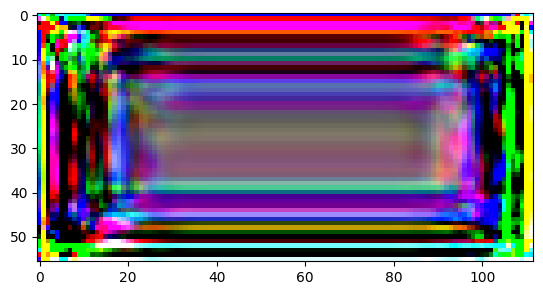

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..9.503606].


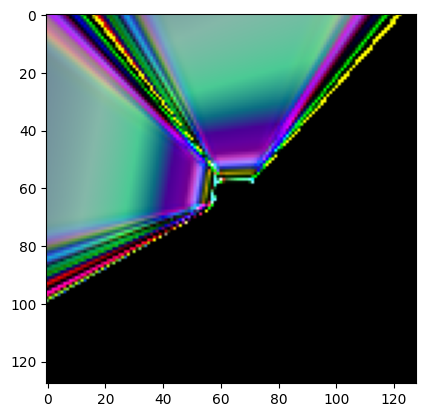

In [173]:
from matplotlib import pyplot as plt 

img = out_8[0].permute([1,2,0])[:,:,0:3].cpu()
vol = volume[0].permute([1,2,3,0])[:,:, -1, 0:3].cpu()

plt.imshow(img)
plt.show()
plt.imshow(vol)


In [31]:
import torchvision

class UpsamplingConcat(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2):
        super().__init__()

        self.upsample = nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=False)

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x_to_upsample, x):
        x_to_upsample = self.upsample(x_to_upsample)
        x_to_upsample = torch.cat([x, x_to_upsample], dim=1)
        return self.conv(x_to_upsample)

class Encoder_res50(nn.Module):
    def __init__(self, C):
        super().__init__()
        self.C = C
        resnet = torchvision.models.resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-4])
        self.layer3 = resnet.layer3

        self.depth_layer = nn.Conv2d(512, self.C, kernel_size=1, padding=0)
        self.upsampling_layer = UpsamplingConcat(1536, 512)

    def forward(self, x):
        x1 = self.backbone(x)
        x2 = self.layer3(x1)
        x = self.upsampling_layer(x2, x1)
        x = self.depth_layer(x)

        return x

net = Encoder_res50(128)

out = net(grd_imgs_cat)

c:\Users\dimitris\miniconda3\envs\condapy310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\dimitris\miniconda3\envs\condapy310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
out.shape

torch.Size([2, 128, 56, 112])